In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import math 
from collections import deque

In [238]:
class prepare_data():
    
    def __init__(self, episode_length):
        self.episode_length = episode_length
        self.companyList = ['0005','0011','0023','0388','0939','1299','1398','2388','2628','3328','3988',
               '0002','0003','0006','0836','1038','0004','0012','0016','0017','0083','0101','0688','0823'
               ,'1109','0019','0027','0066','0135','0144','0151','0175','0267'
               ,'0293','0386','0700','0762','0857','0883','0941','0992','1044','1088','1928','2319']
        self.dataCentre = self.processing_data()
        
        
    def import_data(self):
        ## import data from csv file using the companyList
        companyLibrary = {} #create a library to store all 

        for company in self.companyList:
            data = pd.read_csv('../historicaldata/'+'HKG'+company+'.csv', header=0, index_col=0)
            companyLibrary['HKG'+company] = data
        
        #clear data
        for company in self.companyList:
            companyLibrary['HKG'+company] = companyLibrary['HKG'+company][~companyLibrary['HKG'+company].index.duplicated(keep='first')]
            #replece volume = 0 to mean volume
            companyLibrary['HKG'+company]['Volume'] = companyLibrary['HKG'+company]['Volume'].replace(0, np.mean(companyLibrary['HKG'+company]['Volume']))
            if companyLibrary['HKG'+company].isnull().sum().any() != 0:
                print ('Symbol:',company)
        
        return companyLibrary 
    
    def make_episodes(self, data):
        
        """make episodic data"""
        ##closing price is the only observation now... should extend to include volumn late
        episodic_data = data.values[0*self.episode_length:(0+1)*self.episode_length, 3].reshape((1, self.episode_length))
        num_episode = len(data)//self.episode_length
        for i in range(1,num_episode):
            episode = data.values[i*self.episode_length:(i+1)*self.episode_length, 3].reshape((1, self.episode_length))
            episodic_data = np.concatenate((episodic_data, episode), axis=0)
            
            
        #if len(data)%self.episode_length != 0:
            #episodic_data = np.concatenate(([data.iloc[self.episode_length*num_episode:, 3].values],episodic_data),axis=0)
            
        
        return episodic_data
    
    def normalized(self, episodic_data):
        
        ##divide all episode by its first value in order to normalize it
        L = episodic_data.shape[0]
        normalized = np.divide(episodic_data, episodic_data[:,0].reshape((L, 1)))
            
        return normalized
    
    def processing_data(self):
        
        companyLibrary = self.import_data()
        
        episodic_data = self.make_episodes(companyLibrary['HKG'+self.companyList[0]])
        dataCentre = episodic_data
        for i in range(1,len(self.companyList)): 
            episodic_data = self.make_episodes(companyLibrary['HKG'+self.companyList[i]])
            dataCentre = np.concatenate((dataCentre, episodic_data), axis=0)
         
        dataCentre = self.normalized(dataCentre)
        return dataCentre

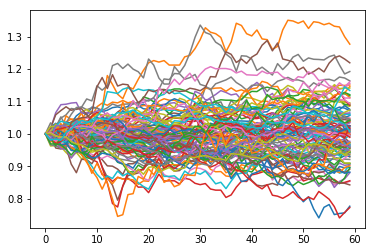

In [255]:
data = prepare_data(episode_length=60)
a = data.dataCentre
for i in range(100):
    plt.plot(a[i, :])

plt.show()

In [245]:
class environment():
    ## market environment
    
    def __init__(self, episode_length):
        #parameters to describe the makert environment 
        self.episode_length = episode_length
        self.train, self.test = self.trainTest()
        
        
    def registerAgent(self, obs_size=14):
        """
        register agents 
        initialise an agent, and stepCount = 0
        
        
        """
        self.agent = agent(obs_size)
        self.stepCount = 0
        
    def reset(self):
        '''
        Draw a ramdom episode from train data
        initialize the env variable episode
        initialize stepCount = 0
        
        '''
        draw_episode = np.random.randint(self.train.shape[0])
        self.episode = self.train[draw_episode, :].reshape((1, self.episode_length))
        
        state = self.getEnvState(self.agent.obs_size) 
        self.state = state 
        self.cost = 0
        self.stepCount = 0 
        self.agent.wallet = []
        self.agent.position = 0
        return state
        
    def trainTest(self, split_ratio=0.9):
        data = prepare_data(self.episode_length)
        dataCentre = data.dataCentre
        
        index = np.random.permutation(dataCentre.shape[0])
        dataCentre_shuffled = dataCentre[index, :]
        
        L = math.floor(dataCentre.shape[0]*split_ratio)
        train = dataCentre_shuffled[:L, :]
        test = dataCentre_shuffled[L:, :]
        
        return train, test 
    
    
    def step(self):
        """return the next position and state, done"""
        #previous state, position 
        state = self.state 
        position = self.agent.position
        
        
        self.stepCount += 1 #increase stepCount by 1
         
        
        #next postion and state 
        action = self.agent.action(state)
        position_new = self.agent.updatePosition(action)
        state_new = self.getEnvState(self.agent.obs_size)
        
        assert(state.shape == state_new.shape), "Wrong dimensions!"
        
        if position_new == 1 and position == 0:
            cost = state[:, -1]
            self.cost = cost #update cost
        
        #update the position and state 
        self.state = state_new 
        self.agent.position = position_new
        
        #calculate reward if agent changes its position from long(1) to short(0)
        if position_new == 0 and position == 1:
            reward = state[:, -1] - self.cost
            reward = np.squeeze(reward)
        else:
            reward = 0
            reward = np.squeeze(reward)
        
        done = False
        
        if self.stepCount > self.episode_length- self.agent.obs_size-1:
            done = True
        
            
        self.agent.memory.append((state, position, action, reward, position_new, state_new))
        self.agent.wallet.append(reward)    

        return (position_new, state_new, reward, done)
    
    def getEnvState(self, obs_size):
        """get environment's state"""
        state = self.episode[:, self.stepCount:(self.stepCount+obs_size)]
        return state
     
    def checkAction(self, ): ##agent's move
         
        ##plot the graph of price in an episode
        ##add indicators on the graph to indicate agent's action
        pass
        

In [256]:
class agent():
    
    def __init__(self, obs_size=14, inital_wealth = 0, position = 0):
        
        self.obs_size = obs_size
        self.initial_wealth = 0
        self.position = position
        self.memory = deque()
        self.wallet = []
        
    def updatePosition(self, action):
        
        """Update position according to the action
            position = 1 means not holding a stock, position = 0 means holding a stock
        """
        action = action 
        position = self.position
        
        if action ==1:
            if position == 0:
                position = 1
            elif position == 1:
                position = 0
        
        self.position = position
        
        return position
    
    def action(self, state):
        """
        action = 1 means change position, action =0 means dont change position 
        
        """
        #full state =  state + self.position 
        action = np.random.randint(2, size=1) #take random action 
        
        return action 

In [257]:
env = environment(episode_length=246)
train, test = env.trainTest(split_ratio=0.9)
env.registerAgent(obs_size=14)

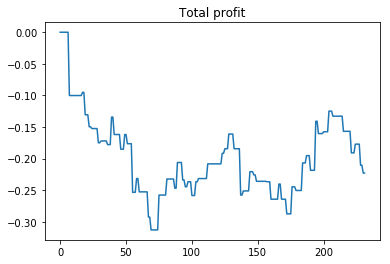

In [258]:
state = env.reset()
done = False
while not done:
    position_new, state_new, reward, done = env.step()

plt.plot(np.cumsum(np.squeeze(env.agent.wallet)))
plt.title('Total profit')
plt.show()

In [233]:
itera = 10000
rewardList = []
for i in range(itera):
    
    state = env.reset()
    done = False
    while not done:
        position_new, state_new, reward, done = env.step()
    
    rewardList.append(np.mean(env.agent.wallet))

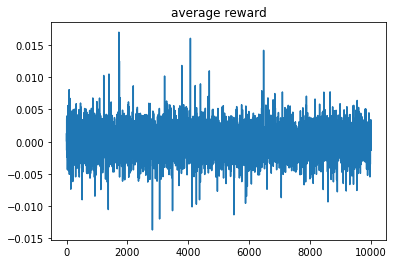

In [234]:
plt.plot(np.squeeze(rewardList))
plt.title('average reward')
plt.show()

In [279]:
### DQN 
### just copy from a book.... need to be modified 
class Qnetwork():
    
    def __init__(self, h_size):
        self.scalarInput = tf.placeholder(shape=[None, 84*84*3,], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn,num_outputs=32,
                                                    kernel_size=[8,8],stride=[4,4],
                                                    padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1,num_outputs=64,
                                                    kernel_size=[4,4],stride=[2,2],
                                                    padding='VALID', biases_initializer=None) 
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2,num_outputs=64,
                                                    kernel_size=[3,3],stride=[1,1],
                                                    padding='VALID', biases_initializer=None) 
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3,num_outputs=512,
                                                    kernel_size=[7,7],stride=[1,1],
                                                    padding='VALID', biases_initializer=None) 
        #tf.split()
        #2: split into two part , 3: dimension to split
        self.streamAC, self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,
                                                                          keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions,dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), 
                              reduction_indices=1)
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate= 0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
